In [2]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne

# Auto-encoders 101
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We'll start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We'll experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you're about to learn is very simple compared to recent advances (e.g. [the Ladder network](https://arxiv.org/abs/1507.02672) and [VAEs](https://arxiv.org/abs/1312.6114)). However, the basic idea stays the same.

AEs are used within unsupervised learning, in which you do not have a target $y$. Instead it *encodes* an input $x$ into a latent state $z$ and decodes $z$ into a reconstruction $\hat{x}$. This way the parameters of the network can be optimized w.r.t. the difference between $x$ and $\hat{x}$. Depending on the input distribution, the difference can be measured in various ways, e.g. mean squared error (MSE). In many applications the auto-encoder will find an internal state of each data point corresponding to a feature. So if we are to model the MNIST dataset, one could expect that the internal state would correspond to a digit-class and/or the shape.

*The exercises are found at the bottom of the notebook*

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes to speed up training.

In [4]:
from sklearn.utils import shuffle

# To speed up training we'll only work on a subset of the data containing only the numbers 0, 1.
data = np.load('../week1/mnist.npz')
num_classes = 2
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = data['X_train'][idxs_train].astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)


x_valid = data['X_valid'][idxs_valid].astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = data['X_test'][idxs_test].astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

training set dim(10610, 784).
validation set dim(2055, 784).
test set dim(2115, 784).


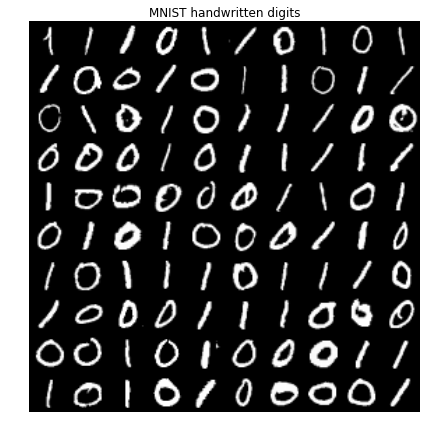

In [5]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using relu units as non-linearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid non-linearity to model the reconstruction.

In [7]:
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import rectify, sigmoid

#define the model
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,num_features))
l_enc = DenseLayer(incoming=l_in, num_units=128, nonlinearity=rectify)
l_z = DenseLayer(incoming=l_enc, num_units=2, nonlinearity=None) # None indicates a linear output.
l_dec = DenseLayer(l_z, num_units=128, nonlinearity=rectify)
l_out = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid) # iid pixel intensities between 0 and 1.

Following we define the Theano functions for training and evaluation.

In [8]:
from lasagne.objectives import squared_error, binary_crossentropy

sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of an input batch.

# Get network output
train_out, train_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=False)
eval_out, eval_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=True)

# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

cost = squared_error(train_out, sym_x).mean()
eval_cost = squared_error(eval_out, sym_x).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)

# Set the update function for parameters 
# you might want to experiment with more advanced update schemes like adam, rmsprob, adadelta etc.
updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.25)


f_eval = theano.function([sym_x],
                     [eval_cost, eval_out, eval_z], on_unused_input='warn')

f_train = theano.function([sym_x],
                          [cost, train_out, train_z],
                          updates=updates, on_unused_input='warn')

In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

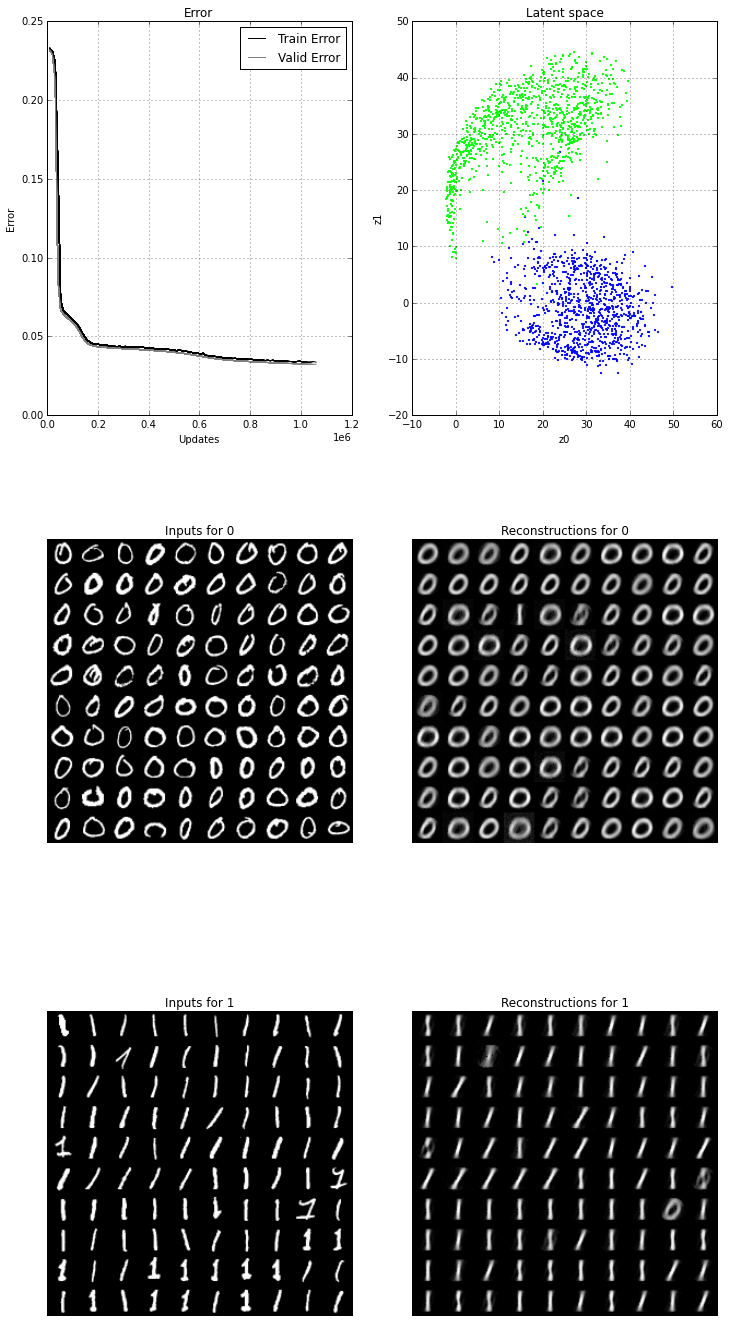

In [9]:
batch_size = 100
num_epochs = 100
learning_rate = 0.1
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
plt.figure(figsize=(12, 24))

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)    
            x_batch = x_train[idxs]
            batch_loss, train_out, train_z = f_train(x_batch) #this will do the complete backprob pass
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)]

        eval_loss, eval_out, eval_z = f_eval(x_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(num_classes+1,2,1)
        plt.title('Error')
        plt.legend(['Train Error', 'Valid Error'])
        plt.xlabel('Updates'), plt.ylabel('Error')
        plt.plot(updates, train_loss, color="black")
        plt.plot(updates, valid_loss, color="grey")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(num_classes+1,2,2)
        plt.cla()
        plt.title('Latent space')
        plt.xlabel('z0'), plt.ylabel('z1')
        color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
        for i in range(num_classes):
            clr = next(color)
            plt.scatter(eval_z[targets_valid==i, 0], eval_z[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
        plt.grid('on')
        
        c=0
        for k in range(3, 3 + num_classes*2, 2):
            plt.subplot(num_classes+1,2,k)
            plt.cla()
            plt.title('Inputs for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            plt.subplot(num_classes+1,2,k+1)
            plt.cla()
            plt.title('Reconstructions for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = eval_out[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            c+=1
      
        
        plt.savefig("out51.png")
        display(Image(filename="out51.png"))
        clear_output(wait=True)
        
except KeyboardInterrupt:
    pass
    

### Exercise 1 - Analyzing the AE
1. The above implementation of an AE is very simple.
    - *Experiment with the number of layers and non-linearities in order to improve the reconstructions.*
    - *What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?*
    - *Try to increase the number of digit classes in the training set and analyze the results.*
    - *Test different optimization algorithms and decide whether you should use regularizers*.
       
2. Currently we optimize w.r.t. mean squared error. 
    - *Find another error function that could fit this problem better.* 
    - *Evaluate whether the error function is a better choice and explain your findings.*

3. Complexity of the bottleneck.
    - *Increase the number of units in the latent layer and train.*
    - *Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*

### Exercise 2 - Adding classification (for the ambitious)
The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class (implemented below). As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from week1) where you:
    - *Train on the labeled dataset and evaluate the results.*
2. Build a second classifier and train on the latent output $z$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output and reconstruction.

labeled training set dim(20, 784).


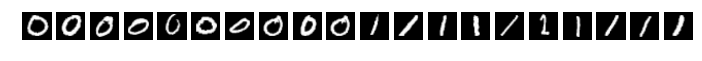

In [10]:
# Generate a subset of labeled data points

num_labeled = 10 # You decide on the size of the fraction...

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(targets_train == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_train[idxs_train_l]
targets_train_l = targets_train[idxs_train_l]
print("labeled training set dim(%i, %i)." % x_train_l.shape)

plt.figure(figsize=(12, 7))
for i in range(num_classes*num_labeled):
    im = x_train_l[i].reshape((28, 28))
    plt.subplot(1, num_classes*num_labeled, i + 1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')